# $\textit{By Agustin Gullino, Gonzalo Linares, Mariano Dolhare}$

In [ ]:
import zipfile
from matplotlib import pyplot as plt
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Cargamos el embedding de fasttext y el texto del libro de Sherlock Holmes

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!wget -O Sherlock.txt https://www.gutenberg.org/ebooks/48320.txt.utf-8
!unzip wiki-news-300d-1M.vec.zip

--2023-11-02 13:21:39--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 65.8.243.111, 65.8.243.25, 65.8.243.97, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|65.8.243.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M   201MB/s    in 3.6s    

2023-11-02 13:21:43 (181 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

--2023-11-02 13:21:44--  https://www.gutenberg.org/ebooks/48320.txt.utf-8
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://www.gutenberg.org/cache/epub/48320/pg48320.txt [following]
--2023-11-

In [ ]:
with open("Sherlock.txt", 'r', encoding='utf-8') as file:
    book = file.read()

In [ ]:
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr|no|No)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov|edu|me)"
digits = "([0-9])"
multiple_dots = r'\.{2,}'

def split_into_sentences(text: str) -> list[str]:
    """
    Split the text into sentences.

    If the text contains substrings "<prd>" or "<stop>", they would lead
    to incorrect splitting because they are used as markers for splitting.

    :param text: text to be split into sentences
    :type text: str

    :return: list of sentences
    :rtype: list[str]
    """
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    text = re.sub(multiple_dots, lambda match: "<prd>" * len(match.group(0)) + "<stop>", text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = ['<SOS> ' + s.strip() + ' <EOS>' for s in sentences]
    if sentences and not sentences[-1]: sentences = sentences[:-1]
    return sentences

Separamos el libro en oraciones, agregando las palabras "sos" y "eos". Consideramos varias excepciones para separarlas. El codigo utilizado como base se encuentra en: https://stackoverflow.com/questions/4576077/how-can-i-split-a-text-into-sentences

In [ ]:
book = split_into_sentences(book)

In [ ]:
book[1000:1002]

['<SOS> I had come to the conclusion that he had dropped asleep, and indeed was nodding myself, when he suddenly sprang out of his chair with the gesture of a man who has made up his mind, and put his pipe down upon the mantel-piece. <EOS>',
 '<SOS> “Sarasate plays at the St. James’s Hall this afternoon,” he remarked. <EOS>']

Tokenizamos

In [ ]:
maxTokens = 5000
token = Tokenizer(num_words=maxTokens,
                  filters='!"“”#$%&()*+,.-/:;=?@[\\]^_`{|}~\t\n\ufeff\u2002', lower=True,
                  split=' ', char_level=False, oov_token=None)
token.fit_on_texts(book)

In [ ]:
sequences = token.texts_to_sequences(book)

In [ ]:
maxLen = len(max(sequences, key=len))

In [ ]:
maxLen

153

In [ ]:
def create_dataset(sequence):
    inputs = []
    outputs = []
    for i, sent in enumerate(sequence):
        for j in range(1, len(sent)-1):
          inputs.append(sent[:j])
          outputs.append([sent[j]])

    return inputs, outputs

Generamos los datos de train y test para entrenar redes *many to one*

In [ ]:
X, y = create_dataset(sequences)
x_train = pad_sequences(X, maxlen=maxLen)
y_train = np.array(y)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3)

In [ ]:
token.sequences_to_texts([X[21]])

['<sos> the project gutenberg ebook of adventures of sherlock holmes this ebook is for the use of anyone anywhere in the united']

In [ ]:
token.sequences_to_texts([y[21]])

['states']

In [ ]:
reverse_dictionary = token.index_word
dictionary = dict([(value, key) for (key, value) in reverse_dictionary.items()])
num_words=len(dictionary)+1

In [ ]:
import codecs
import IPython.display as ipd
from IPython.display import Audio, update_display
from ipywidgets import IntProgress

EMB = "wiki-news-300d-1M.vec"
N = 1000000

#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open(f'./{EMB}', encoding='utf-8')
bar = IntProgress(min=0, max=N)
ipd.display(bar)

i = 0
for n, line in enumerate(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    if n//(N//100) > i:
          bar.value = n
          i += 1
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


IntProgress(value=0, max=1000000)

found 999995 word vectors


Generamos la matriz de embeddings

In [ ]:
embed_dim=300
embedding_matrix=np.zeros([num_words, embed_dim])
for word, idx in dictionary.items():
  if word in embeddings_index:
    embedding_matrix[idx,:]=embeddings_index[word]

In [ ]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense, Input, Concatenate, Dot, RepeatVector, TimeDistributed, Multiply, Lambda, Flatten, Activation, Reshape, BatchNormalization, GRU, SimpleRNN
import tensorflow.keras.backend as K
from tensorflow.keras.activations import softmax
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

nb_words = len(embedding_matrix) #Vocabulary size
embed_dim = len(embedding_matrix[0]) #Vectorization dim
value_dim = 50
maxLen = len(x_train[0])

Luego de entrenar varias redes variando sus hiperparametros, concluimos que diejon mejores resultados la LSTM, seguida de la GRU.

# Red LSTM

In [ ]:
input_layer = Input(shape=(maxLen,)) #Cantidad maxima de la frase de entrada, estos son los timesteps para este caso
embedding_layer = Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=maxLen, trainable=False, mask_zero=True)(input_layer)
lstm = LSTM(value_dim, return_sequences=False, activation="tanh", recurrent_dropout=0.4)(embedding_layer)
drop = Dropout(0.4)(lstm)
dense3 = Dense(100, activation='relu')(drop)
drop3 = Dropout(0.4)(dense3)
dense4 = Dense(nb_words, activation='softmax')(drop3)
model = Model(inputs=input_layer, outputs=dense4)

# Red GRU

In [ ]:
model2 = tf.keras.Sequential()
model2.add(Input(shape=(maxLen,)))
model2.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=maxLen, trainable=True, mask_zero=True))
model2.add(GRU(value_dim, return_sequences=False, activation="tanh"))
model2.add(Dropout(0.4))
model2.add(Dense(100, activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(nb_words, activation='softmax'))

# Red Convolucional

In [ ]:
num_filters=12
model3 = tf.keras.Sequential()
model3.add(Input(shape=(maxLen,)))
model3.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=maxLen, trainable=True, mask_zero=True))
model3.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model3.add(MaxPooling1D(2))
model3.add(Conv1D(num_filters*2, 7, activation='relu', padding='same'))
model3.add(GlobalMaxPooling1D())
model3.add(Dropout(0.4))
model3.add(Dense(100, activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(nb_words, activation='softmax'))

# Red SimpleRNN

In [ ]:
model4 = tf.keras.Sequential()
model4.add(Input(shape=(maxLen,)))
model4.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=maxLen, trainable=True, mask_zero=True))
model4.add(SimpleRNN(value_dim, return_sequences=False, activation="tanh"))
model4.add(Dropout(0.4))
model4.add(Dense(100, activation='relu'))
model4.add(Dropout(0.4))
model4.add(Dense(nb_words, activation='softmax'))

In [ ]:
#val_loss: 5.38
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 153)]             0         
                                                                 
 embedding (Embedding)       (None, 153, 300)          2652900   
                                                                 
 lstm (LSTM)                 (None, 50)                70200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 100)               5100      
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 8843)              893143

In [ ]:
#val_loss: 5.55
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 153, 300)          2652900   
                                                                 
 gru (GRU)                   (None, 50)                52800     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 100)               5100      
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 8843)              893143    
                                                                 
Total params: 3,603,943
Trainable params: 3,603,943
Non-

In [ ]:
#val_loss: 6.3046
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 153, 300)          2652900   
                                                                 
 conv1d (Conv1D)             (None, 153, 12)           25212     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 76, 12)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 76, 24)            2040      
                                                                 
 global_max_pooling1d (Globa  (None, 24)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_4 (Dropout)         (None, 24)               

In [ ]:
#val_loss: 5.53
model4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 153, 300)          2652900   
                                                                 
 simple_rnn (SimpleRNN)      (None, 50)                17550     
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 100)               5100      
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 8843)              893143    
                                                                 
Total params: 3,568,693
Trainable params: 3,568,693
No

In [ ]:
callbackROP = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)
callbackES = EarlyStopping(monitor='val_loss', patience=10)
callbackCHK = ModelCheckpoint(filepath='/tmp/checkpoint', save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam')

In [ ]:
model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=512, epochs=50, callbacks=[callbackROP, callbackES, callbackCHK])

Epoch 1/50
147/147 [==============================] - 96s 599ms/step - loss: 7.1174 - val_loss: 6.4912 - lr: 0.0010
Epoch 2/50
147/147 [==============================] - 88s 602ms/step - loss: 6.3946 - val_loss: 6.3464 - lr: 0.0010
Epoch 3/50
147/147 [==============================] - 88s 602ms/step - loss: 6.2662 - val_loss: 6.2560 - lr: 0.0010
Epoch 4/50
147/147 [==============================] - 88s 596ms/step - loss: 6.1677 - val_loss: 6.1288 - lr: 0.0010
Epoch 5/50
147/147 [==============================] - 87s 591ms/step - loss: 6.0416 - val_loss: 5.9834 - lr: 0.0010
Epoch 6/50
147/147 [==============================] - 87s 590ms/step - loss: 5.9274 - val_loss: 5.8830 - lr: 0.0010
Epoch 7/50
147/147 [==============================] - 87s 591ms/step - loss: 5.8327 - val_loss: 5.8030 - lr: 0.0010
Epoch 8/50
147/147 [==============================] - 87s 590ms/step - loss: 5.7489 - val_loss: 5.7384 - lr: 0.0010
Epoch 9/50
147/147 [==============================] - 86s 588ms/step - l

# Greedy search + ArgMax

Dada la naturaleza de la generacion de oraciones, este metodo demostro generar recurrentemente loops de palabras. Esto es debido a que siempre agarramos la de mayor probabilidad y siendo que la distribucion de palabras en estas redes que no estan muy overfitteadas suelen tener ciertas palabras muy probables, entonces termina generando el efecto de que a pesar de que agregamos nuevas parlabras para predecir, estas no son lo suficientes para que la red genere estados diferentes.

In [ ]:
def greedy_search(question, outputLen, model):

  out = 0
  response = []
  reply = question
  finished = False

  while out != token.texts_to_sequences(["<eos>"])[0][0] and len(response) < outputLen:
      out = pad_sequences(reply, maxlen=maxLen)
      out = model.predict(out, verbose=0)
      out = int(np.argmax(out))
      reply[0] += [out]
      response.append(out)

  return response

In [ ]:
question = token.texts_to_sequences(["<sos> sherlock"])

In [ ]:
def from_seq_to_text(seq):
    return token.sequences_to_texts([seq])

response = greedy_search(question, 15, model)
rta = from_seq_to_text(response)
rta

['holmes was a little of the matter of the matter of the matter of the']

# Greedy search + T

Para este caso, se obtuvieron mejores resultados que con el ArgMax. En primer lugar se noto que si se ajusta la temperatura a un valor adecuado, los loops de palabras practicamente desaparecian. Sin embargo, si subiamos mucho la temperatura, los modelos comenzaban a generar palabras de forma practicamente aleatorias, provocando incoherencias gramaticales.

In [ ]:
def changeTemp(a, temperature=1.0, epsilon=1e-10):
    a = np.log(a) / temperature
    sampled_temp = np.exp(a+1e-10)/(np.exp(a+1e-10).sum())
    sampled_temp = sampled_temp/sampled_temp.sum()
    return sampled_temp

In [ ]:
def greedy_search_withT(question, model, max_len=15, T=1.0):

  out = 0
  response = []
  reply = question
  finished = False
  eof = token.texts_to_sequences(["<eos>"])[0][0]

  while out != eof and len(response) < max_len:

      out = pad_sequences(reply, maxlen=maxLen)
      out = model.predict(out, verbose=0)
      temp = changeTemp(out[0], temperature=T)
      out = np.random.choice(range(len(temp)), p=temp)
      reply[0] += [out]
      if out in response:
        finished = True
      else:
        response.append(out)

  return response

Vemos el efecto del cambio de temperatura de la *softmax*.

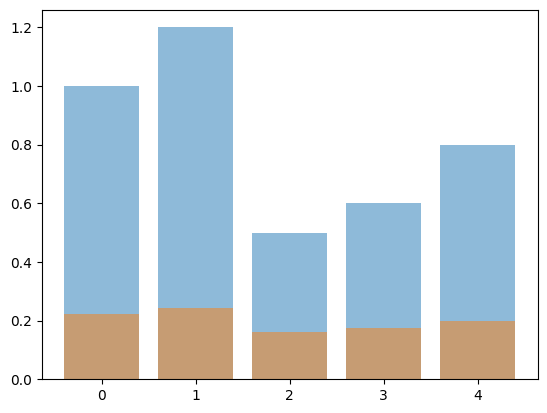

In [ ]:
arr1 = [1, 1.2, 0.5, 0.6, 0.8]
plt.figure()
plt.bar(range(len(arr1)), arr1, alpha=0.5)
arr2 = changeTemp(arr1, temperature=2.1)
plt.bar(range(len(arr2)), arr2, alpha=0.5)
plt.show()

In [ ]:
question = token.texts_to_sequences(["<sos> sherlock was walking"])

In [ ]:
def from_seq_to_text(seq):
    return token.sequences_to_texts([seq])

response = greedy_search_withT(question, model, max_len=15, T=1.1)
rta = from_seq_to_text(response)
rta

['through her to this man some unfortunately choked and when he had rushed two dramatic']

# Stochastic beam search + T

Por ultimo, se implemento una funcion recursiva que ejecuta el algoritmo *stochastic beam search*. Se hicieron muchas pruebas con este algoritmo, ya que era de esperar que entre este y anterior sean los algoritmos que mejor debian generar texto. Luego de varias pruebas, encontramos cierta coherencia en la generacion, sobre todo para la red LSTM. Sin embargo, existen ejemplos como los que estas debajo donde la generacion no es muy coherente.

In [ ]:
def stoch_beam_search(kBeams, maxOutputLen, candidatesAndProb, model, T=1.0):

  candidates = candidatesAndProb[0]
  probabilities = candidatesAndProb[1]

  if maxOutputLen < 1:
    return candidates, probabilities
  else:
    possibleCand = [0]*kBeams
    possibleProb = [0]*kBeams

    #Calculamos los candidatos para cada rama, kBeams candidatos maximos
    for curr in candidates:
      out = pad_sequences([curr], maxlen=maxLen)
      out = model.predict(out, verbose=0) #Probabilidades
      temp = changeTemp(out[0], temperature=T)
      newCandidates = np.argsort(temp)[::-1][:kBeams] #Agarramos los indices de los k-elementos con mas prob
      newCandidates = [[num] for num in newCandidates] #Convertimos los numeros en listas de numeros por compatibilidad con pad_sequences
      newCandProba = [temp[i] for i in newCandidates] #Agarramos su probabilidad

      #Elegimos los kBeams caminos con mas probabilidad
      for i, prob in enumerate(newCandProba): #Agarramos la probabilidad de cada candidato
        for j in range(len(possibleProb)): #Para cada probabilidad maxima guardada
          if possibleProb[j] < prob and newCandProba[i] not in possibleCand:
            possibleProb[j] = prob
            possibleCand[j] = newCandProba[i]

    concatenated = np.concatenate((candidates, newCandidates), axis=1)
    probabilities = np.multiply(probabilities, newCandProba)

    return stoch_beam_search(kBeams, maxOutputLen-1, (concatenated, probabilities), model)

In [ ]:
question = token.texts_to_sequences(["<sos> watson is"])

In [ ]:
maxOutputLen = 10
kBeams = 7
candidates = (question*kBeams, 1*kBeams)

outSeq, outProb = stoch_beam_search(kBeams, maxOutputLen, candidates, model=model, T=0.9)
result = token.sequences_to_texts(outSeq)

for i, sent in enumerate(result):
  print(f"prob: {outProb[i][0]:.10f} - Rta: {sent}")

prob: 0.0000000058 - Rta: <sos> watson is a to to holmes said been be to to the
prob: 0.0000000000 - Rta: <sos> watson is the that that he i a the the and a
prob: 0.0000000000 - Rta: <sos> watson is not not i i was not have in in my
prob: 0.0000000000 - Rta: <sos> watson is it the not that is the me and for it
prob: 0.0000000000 - Rta: <sos> watson is no said much the to no do out at me
prob: 0.0000000000 - Rta: <sos> watson is very a a you had done see up of his
prob: 0.0000000000 - Rta: <sos> watson is you so said she have to go back with him


In [ ]:
def perplexity_old(model, init_seq, length):
  seq = init_seq
  score = 1
  for i in range(length):
    out = pad_sequences(seq, maxlen=maxLen)
    out = model.predict(out, verbose=0)
    argmax = np.argmax(out[0])
    seq = [np.concatenate([seq[0], [argmax]])]
    print(seq)
    score *= (1/out[0][argmax])**(1/length)
  return score

def perplexity(model, init_seq):
  seq = init_seq
  score = 1
  for i in range(2, len(seq[0])):
    out = pad_sequences([seq[0][:i]], maxlen=maxLen)
    out = model.predict(out, verbose=0)
    score *= (1/out[0][seq[0][i]])**(1/len(seq[0]))
  return score

En los ejemplos de abajo podemos observar como a partir de la perplejidad podemos determinar que tanta certeza tiene la red de una oracion. Por ejemplo, es de esperar que siendo que Sherlock Holmes es un detective segun el dataset, la red de una perplejidad mas pequeña que para los casos en donde le cambiamos el oficio o afirmamos que es una mascota. Ademas, vemos que la perplejidad para el caso donde decimos que Sherlock era un hombre es mucho mas baja que en los otros casos, indicando que en las palabras existe cierto conocimiento del contexto.

In [ ]:
question = token.texts_to_sequences(["<sos> sherlock holmes was a detective"])
print(question)
score = perplexity(model, question)
score

[[1, 123, 36, 14, 8, 1563]]


8.51712392232643

In [ ]:
question = token.texts_to_sequences(["<sos> sherlock holmes was a doctor"])
print(question)
score = perplexity(model, question)
score

[[1, 123, 36, 14, 8, 345]]


10.886164281166694

In [ ]:
question = token.texts_to_sequences(["<sos> sherlock holmes was a man"])
print(question)
score = perplexity(model, question)
score

[[1, 123, 36, 14, 8, 59]]


4.620224526174586

In [ ]:
question = token.texts_to_sequences(["<sos> sherlock holmes was a pet"])
print(question)
score = perplexity(model, question)
score

[[1, 123, 36, 14, 8, 4374]]


12.217431397765255